In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
import warnings

warnings.filterwarnings("ignore")

# plt.style.use("icml.mplstyle")

In [74]:
EXPLANATORY_VARS = ["d", "K", "norm", "sigma", "n"]
EXPLANATORY_VAR_NAMES = [
    "Dimension ($d$)",
    "Curvature ($K$)",
    "Norm ($\\|\\cdot\\|$)",
    "Standard Deviation ($\\sigma$)",
    "Number of samples ($n$)",
]

# TARGET_VARS = ["delta_mean", "delta_std"]
# TARGET_VAR_NAMES = ["Mean ($\\delta_{mean}$)", "Standard Deviation ($\\delta_{std}$)"]

# TARGET_VARS = ["loc_mle", "scale_mle", "kappa_mle"]
# TARGET_VAR_NAMES = ["Location ($m$)", "Scale ($\\lambda$)", "Asymmetry ($\\kappa$)"]

TARGET_VARS = ["loc_median", "scale_iqr", "skew_quantile"]
TARGET_VAR_NAMES = ["Location ($m$)", "Scale ($\\lambda$)", "Asymmetry ($\\kappa$)"]

# DELTAS_PATH = "https://raw.githubusercontent.com/pchlenski/delta/main/deltas.csv"
DELTAS_PATH = "https://raw.githubusercontent.com/pchlenski/delta/refs/heads/main/deltas_laplace.csv"

In [17]:
# Load the data
deltas = pd.read_csv(DELTAS_PATH, index_col=0).dropna()
deltas.head()

,d,K,norm,sigma,n,trial,loc_median,scale_iqr,skew_quantile,loc_mle,scale_mle,kappa_mle
0,2.0,-2.0,0.0,0.0625,4.0,0.0,0.0,0.076274,-1.0,1.215674e-08,0.069654,2.976490
1,2.0,-2.0,0.0,0.0625,4.0,1.0,0.0,0.442250,-1.0,1.247002e-08,0.162934,2.151264
2,2.0,-2.0,0.0,0.0625,4.0,2.0,0.0,0.074760,-1.0,4.875233e-08,0.078611,3.730853
3,2.0,-2.0,0.0,0.0625,4.0,3.0,0.0,0.139137,-1.0,1.871708e-08,0.077468,2.808386
4,2.0,-2.0,0.0,0.0625,4.0,4.0,0.0,0.073901,-1.0,5.620629e-03,0.002522,98.765710


In [18]:
# Split into K < 0, K = 0, and K > 0

H = deltas[deltas["K"] < 0]
HE = deltas[deltas["K"] <= 0]
E = deltas[deltas["K"] == 0]
SE = deltas[deltas["K"] >= 0]
S = deltas[deltas["K"] > 0]

ALL_GEOMS = [H, E, S]

# Summary statistics

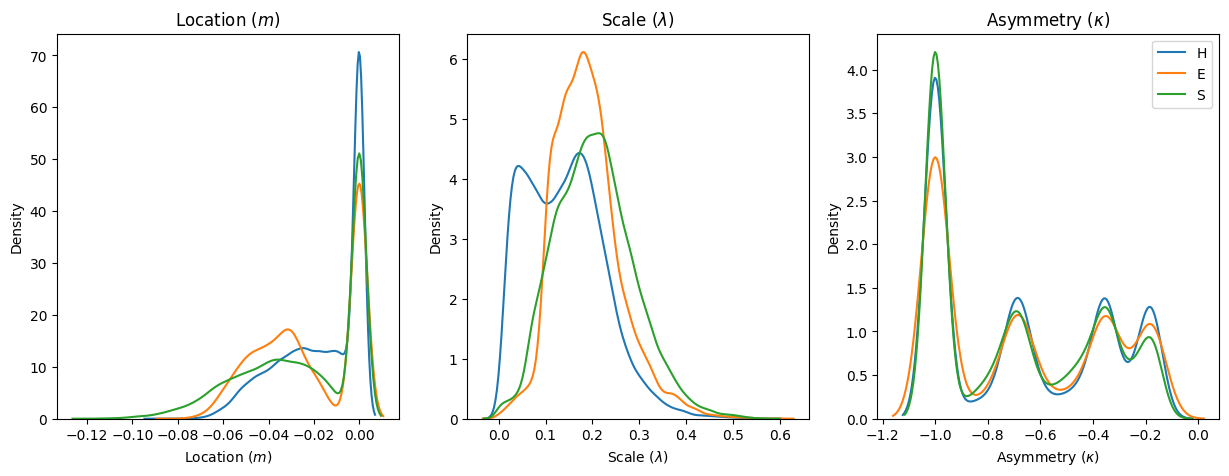

In [75]:
fig, axs = plt.subplots(1, len(TARGET_VARS), figsize=(15, 5))

for i, (target, target_name) in enumerate(zip(TARGET_VARS, TARGET_VAR_NAMES)):
    axs[i].set_title(target_name)
    sns.kdeplot(H[target], ax=axs[i], label="H")
    sns.kdeplot(E[target], ax=axs[i], label="E")
    sns.kdeplot(S[target], ax=axs[i], label="S")
    axs[i].set_xlabel(target_name)
    axs[i].set_ylabel("Density")
    # axs[i].set_yscale("log")
axs[-1].legend()

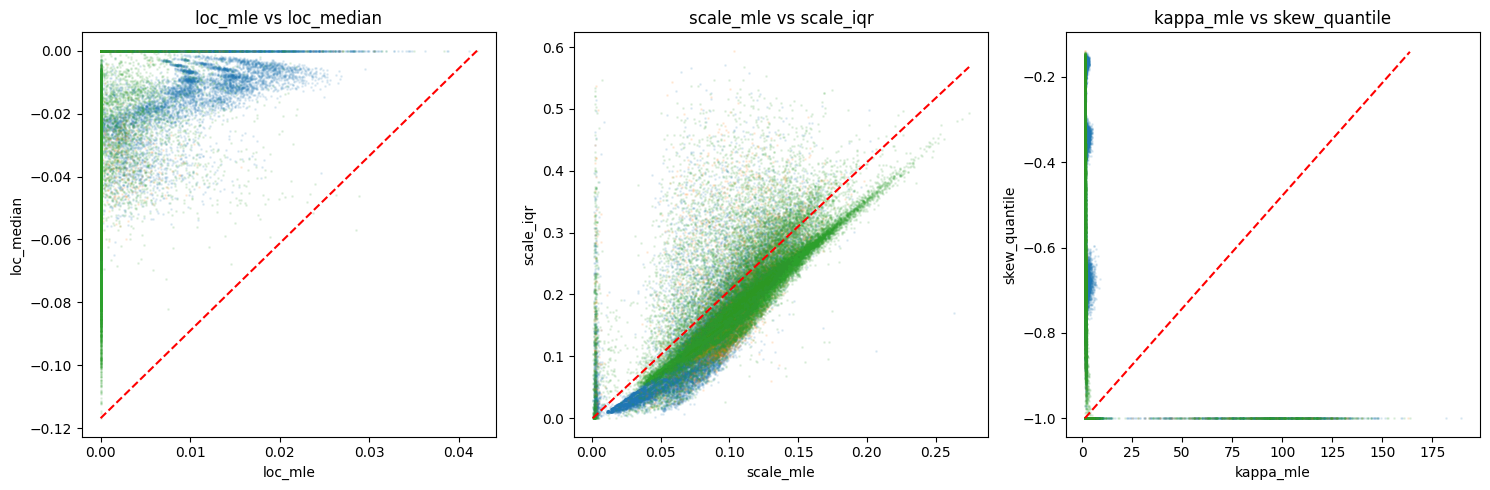

In [76]:
# How good are the approximations?

fig, axs = plt.subplots(1, len(ALL_GEOMS), figsize=(15, 5))

for i, (var1, var2) in enumerate(
    zip(["loc_mle", "scale_mle", "kappa_mle"], ["loc_median", "scale_iqr", "skew_quantile"])
):
    for geom, geom_name in zip(ALL_GEOMS, ["H", "E", "S"]):
        axs[i].scatter(geom[var1], geom[var2], label=geom_name, s=1, alpha=0.1)

    axs[i].set_xlabel(var1)
    axs[i].set_ylabel(var2)
    axs[i].set_title(f"{var1} vs {var2}")
    axs[i].plot([geom[var1].min(), geom[var1].max()], [geom[var2].min(), geom[var2].max()], color="red", linestyle="--")
    # axs[i].set_aspect("equal")

plt.tight_layout()

# Individual variable effects

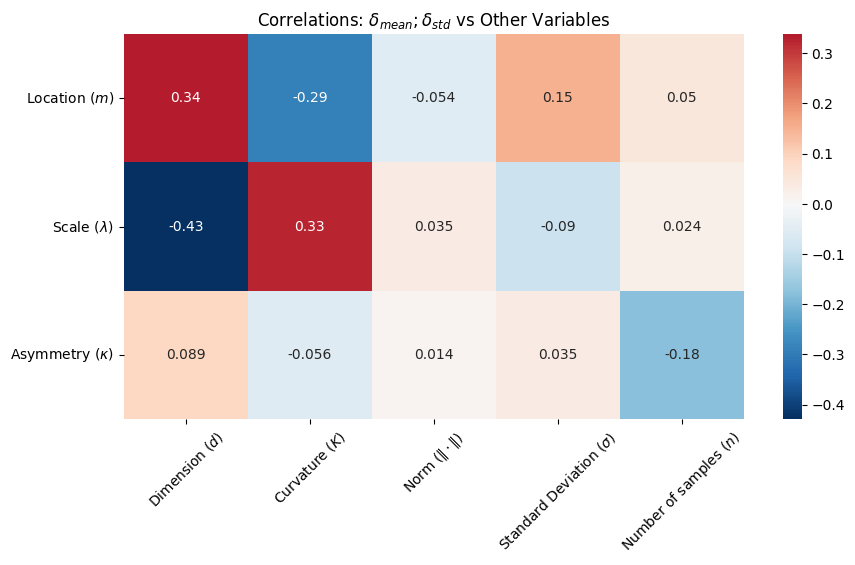

In [23]:
# Analyze relationships between delta_mean/delta_std and other variables

# Compute correlations
corr_matrix = deltas[EXPLANATORY_VARS + TARGET_VARS].corr()

# Visualize correlations
fig = plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix.loc[TARGET_VARS, EXPLANATORY_VARS], annot=True, cmap="RdBu_r", center=0)
plt.title("Correlations: $\\delta_{mean}; \\delta_{std}$ vs Other Variables")
plt.yticks(np.arange(len(TARGET_VAR_NAMES)) + 0.5, TARGET_VAR_NAMES, rotation=0)
plt.xticks(np.arange(len(EXPLANATORY_VAR_NAMES)) + 0.5, EXPLANATORY_VAR_NAMES, rotation=45)
plt.show()

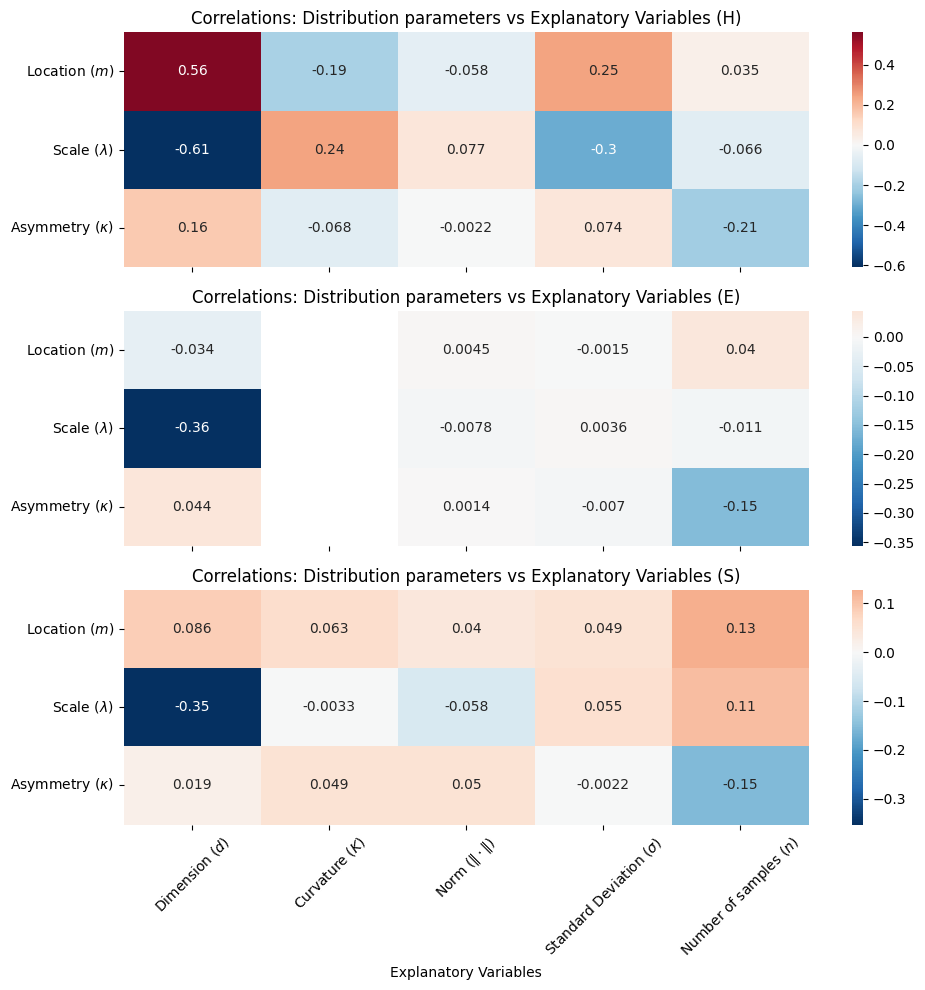

In [60]:
# Same thing but broken down by K
fig, axs = plt.subplots(len(ALL_GEOMS), 1, figsize=(10, 10), sharex=True)

for i, (geom, geom_name) in enumerate(zip(ALL_GEOMS, ["H", "E", "S"])):
    corr_matrix = geom[EXPLANATORY_VARS + TARGET_VARS].corr()
    sns.heatmap(corr_matrix.loc[TARGET_VARS, EXPLANATORY_VARS], annot=True, cmap="RdBu_r", center=0, ax=axs[i])
    axs[i].set_title(f"Correlations: Distribution parameters vs Explanatory Variables ({geom_name})")
    axs[i].set_yticks(np.arange(len(TARGET_VAR_NAMES)) + 0.5)
    axs[i].set_yticklabels(TARGET_VAR_NAMES, rotation=0)
    axs[i].set_xticks(np.arange(len(EXPLANATORY_VAR_NAMES)) + 0.5)
    axs[i].set_xticklabels(EXPLANATORY_VAR_NAMES, rotation=45)
axs[-1].set_xlabel("Explanatory Variables")
plt.tight_layout()
plt.show()

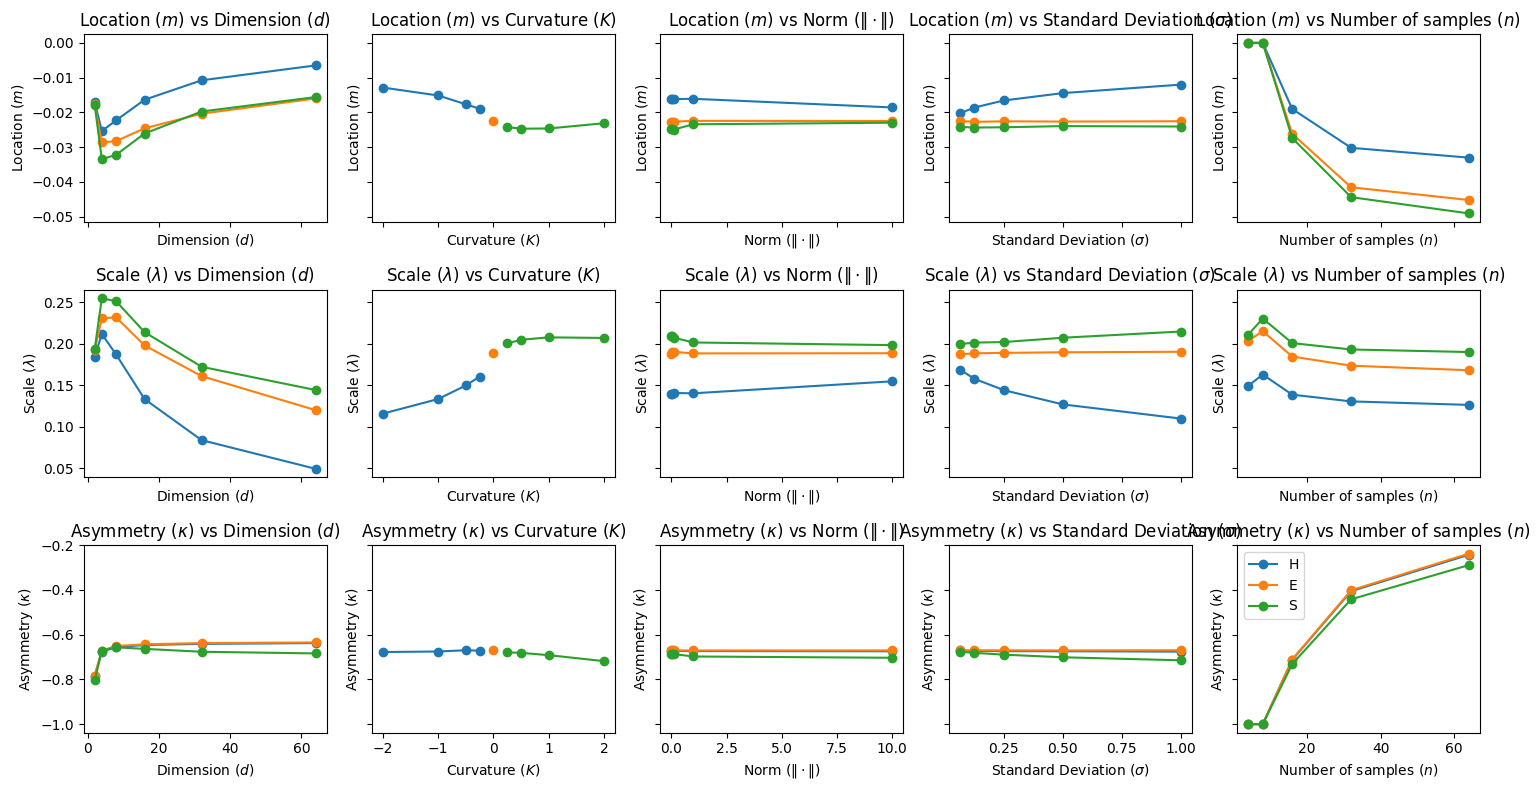

In [77]:
# Same thing but broken down by K
fig, axs = plt.subplots(len(TARGET_VARS), len(EXPLANATORY_VARS), figsize=(15, 8), sharey="row", sharex="col")

for i, (explanatory, explanatory_name) in enumerate(zip(EXPLANATORY_VARS, EXPLANATORY_VAR_NAMES)):
    for j, (target, target_name) in enumerate(zip(TARGET_VARS, TARGET_VAR_NAMES)):
        for geom, geom_name in zip(ALL_GEOMS, ["H", "E", "S"]):
            data_grouped = geom.groupby(explanatory).mean()
            axs[j, i].plot(data_grouped.index, data_grouped[target], label=geom_name, marker="o")
        axs[j, i].set_title(f"{target_name} vs {explanatory_name}")
        axs[j, i].set_xlabel(explanatory_name)
        axs[j, i].set_ylabel(target_name)

axs[-1, -1].legend()
plt.tight_layout()

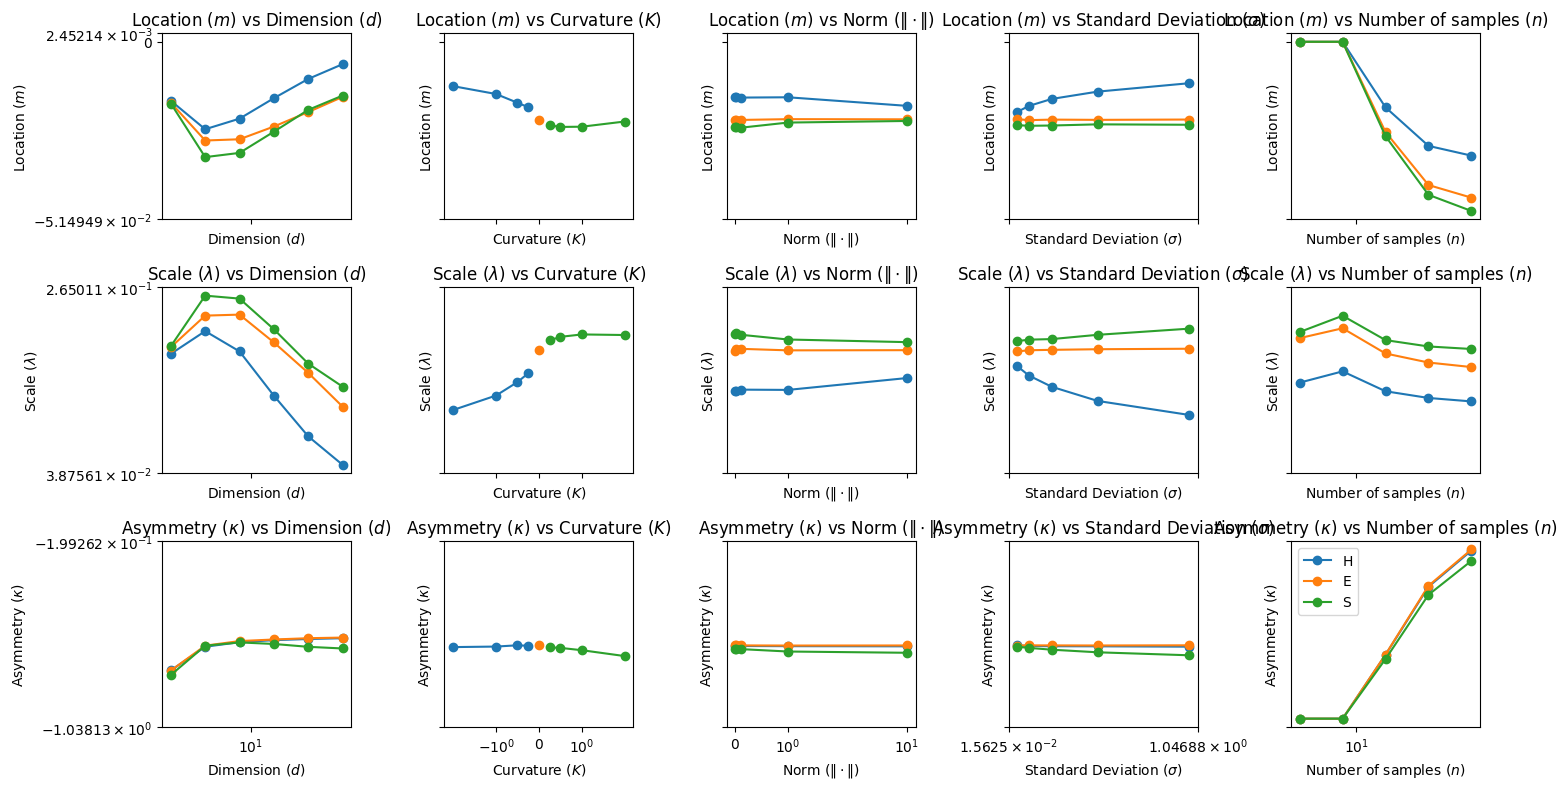

In [78]:
# Same thing but broken down by K
fig, axs = plt.subplots(len(TARGET_VARS), len(EXPLANATORY_VARS), figsize=(15, 8), sharey="row", sharex="col")

for i, (explanatory, explanatory_name) in enumerate(zip(EXPLANATORY_VARS, EXPLANATORY_VAR_NAMES)):
    for j, (target, target_name) in enumerate(zip(TARGET_VARS, TARGET_VAR_NAMES)):
        for geom, geom_name in zip(ALL_GEOMS, ["H", "E", "S"]):
            data_grouped = geom.groupby(explanatory).mean()
            axs[j, i].plot(data_grouped.index, data_grouped[target], label=geom_name, marker="o")
        axs[j, i].set_title(f"{target_name} vs {explanatory_name}")
        axs[j, i].set_xlabel(explanatory_name)
        axs[j, i].set_ylabel(target_name)
        axs[j, i].set_yscale("symlog")
        axs[j, i].set_xscale("symlog")

axs[-1, -1].legend()
plt.tight_layout()

## Bivariate effects

# Deriving scaling laws

## Kitchen sink model

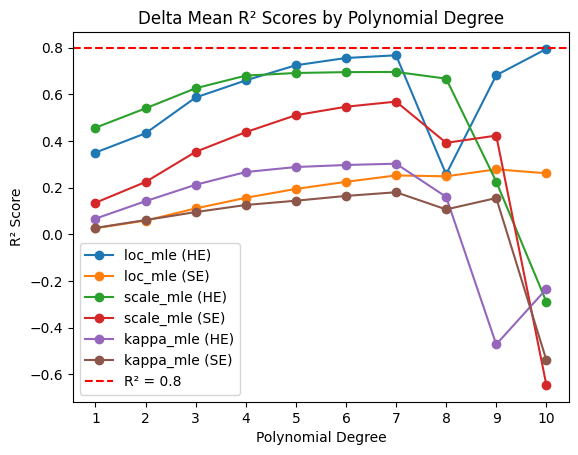

In [ ]:
# How complex do our polynomials need to be to get R² > 0.8?

MAX_DEGREE = 10

delta_mean_scores = {col: {geom: [] for geom in ["HE", "SE"]} for col in TARGET_VARS}
for deg in range(1, MAX_DEGREE + 1):
    poly = PolynomialFeatures(degree=deg, include_bias=False)

    for col in TARGET_VARS:
        for geom in ["HE", "SE"]:
            geom_data = HE if geom == "HE" else SE

            X_poly = poly.fit_transform(geom_data[EXPLANATORY_VARS])
            model = LinearRegression()
            model.fit(X_poly, geom_data[col])
            y_pred = model.predict(X_poly)
            r2 = r2_score(geom_data[col], y_pred)
            delta_mean_scores[col][geom].append(r2)

for col, scores in delta_mean_scores.items():
    plt.plot(range(1, MAX_DEGREE + 1), scores["HE"], label=f"{col} (HE)", marker="o")
    plt.plot(range(1, MAX_DEGREE + 1), scores["SE"], label=f"{col} (SE)", marker="o")
plt.axhline(0.8, linestyle="--", color="red", label="R² = 0.8")

plt.xlabel("Polynomial Degree")
plt.xticks(range(1, MAX_DEGREE + 1))
plt.ylabel("R² Score")
plt.title("Delta Mean R² Scores by Polynomial Degree")
plt.legend()
plt.show()

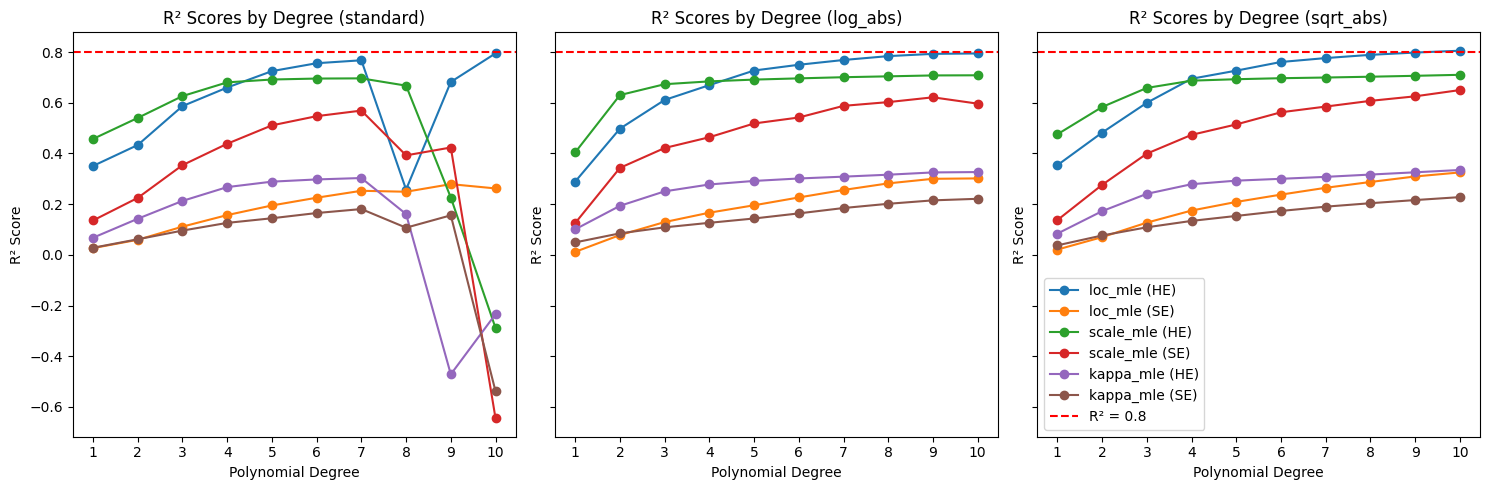

In [65]:
# Same thing, but now with some transformations applied as well

transformations = [
    {"name": "standard", "transform": lambda x: x},
    {"name": "log_abs", "transform": lambda x: np.log(np.abs(x) + 1e-8)},
    {"name": "sqrt_abs", "transform": lambda x: np.sqrt(np.abs(x))},
]

delta_scores = {t["name"]: {col: {geom: [] for geom in ["HE", "SE"]} for col in TARGET_VARS} for t in transformations}

for transform in transformations:
    transform_name = transform["name"]
    transform_func = transform["transform"]

    for deg in range(1, MAX_DEGREE + 1):
        poly = PolynomialFeatures(degree=deg, include_bias=False)

        for col in TARGET_VARS:
            for geom in ["HE", "SE"]:
                geom_data = HE if geom == "HE" else SE
                X_transformed = transform_func(geom_data[EXPLANATORY_VARS])

                X_poly = poly.fit_transform(X_transformed)
                model = LinearRegression()
                model.fit(X_poly, geom_data[col])
                y_pred = model.predict(X_poly)
                r2 = r2_score(geom_data[col], y_pred)
                delta_scores[transform_name][col][geom].append(r2)


fig, axes = plt.subplots(1, len(transformations), figsize=(15, 5), sharey=True)

for i, transform in enumerate(transformations):
    transform_name = transform["name"]
    ax = axes[i]

    for col, scores in delta_scores[transform_name].items():
        ax.plot(range(1, MAX_DEGREE + 1), scores["HE"], label=f"{col} (HE)", marker="o")
        ax.plot(range(1, MAX_DEGREE + 1), scores["SE"], label=f"{col} (SE)", marker="o")

    ax.axhline(0.8, linestyle="--", color="red", label="R² = 0.8")
    ax.set_xlabel("Polynomial Degree")
    ax.set_xticks(range(1, MAX_DEGREE + 1))
    ax.set_ylabel("R² Score")
    ax.set_title(f"R² Scores by Degree ({transform_name})")

ax.legend()
plt.tight_layout()
plt.show()

In [56]:
# Let's print out the equation we actually get here

DEGREE = 2
# VAR_TO_EXPLAIN = "delta_std"
VAR_TO_EXPLAIN = "scale_mle"


# Added X_poly and k to the function signature
def get_equation_str(model, poly_transformer, input_features, target_name, X_poly=None, k=None):
    poly_names = np.array(poly_transformer.get_feature_names_out(input_features))
    coeffs = model.coef_

    if k is not None:
        indices = np.argsort(np.abs(coeffs) * np.std(X_poly, axis=0))[::-1][:k]
        coeffs, poly_names = coeffs[indices], poly_names[indices]

    # This part is unchanged and now uses the filtered lists
    terms = " ".join(f"{'+' if coef >= 0 else '-'} {abs(coef):.4f} * {name}" for coef, name in zip(coeffs, poly_names))

    return f"{target_name} = {model.intercept_:.4f} {terms}"


poly = PolynomialFeatures(degree=DEGREE, include_bias=False)
X_log = transformations[1]["transform"](HE[EXPLANATORY_VARS])
X_poly = poly.fit_transform(X_log)
model = LinearRegression()
model.fit(X_poly, HE[VAR_TO_EXPLAIN])
y_pred = model.predict(X_poly)
r2 = r2_score(HE[VAR_TO_EXPLAIN], y_pred)
print(f"R² for {VAR_TO_EXPLAIN} with log transformation and degree {DEGREE}: {r2:.4f}")

equation_str = get_equation_str(model, poly, EXPLANATORY_VARS, VAR_TO_EXPLAIN)
# Break up equation string to lines < 120 characters
equation_str = "\n".join(" ".join(equation_str.split()[i : i + 20]) for i in range(0, len(equation_str.split()), 10))
print(f"Equation for {VAR_TO_EXPLAIN} with log transformation:\n{equation_str}")

R² for scale_mle with log transformation and degree 2: 0.6304
Equation for scale_mle with log transformation:
scale_mle = -0.0135 + 0.0182 * d - 0.0102 * K + 0.0001 * norm - 0.0044 * sigma +
K + 0.0001 * norm - 0.0044 * sigma + 0.0723 * n - 0.0061 * d^2 - 0.0006 *
0.0723 * n - 0.0061 * d^2 - 0.0006 * d K - 0.0000 * d norm - 0.0027 *
d K - 0.0000 * d norm - 0.0027 * d sigma - 0.0036 * d n - 0.0005 *
d sigma - 0.0036 * d n - 0.0005 * K^2 + 0.0000 * K norm - 0.0006 * K
K^2 + 0.0000 * K norm - 0.0006 * K sigma - 0.0002 * K n + 0.0000 * norm^2
sigma - 0.0002 * K n + 0.0000 * norm^2 - 0.0000 * norm sigma + 0.0000 * norm n
- 0.0000 * norm sigma + 0.0000 * norm n - 0.0009 * sigma^2 - 0.0011 * sigma n -
- 0.0009 * sigma^2 - 0.0011 * sigma n - 0.0117 * n^2
0.0117 * n^2


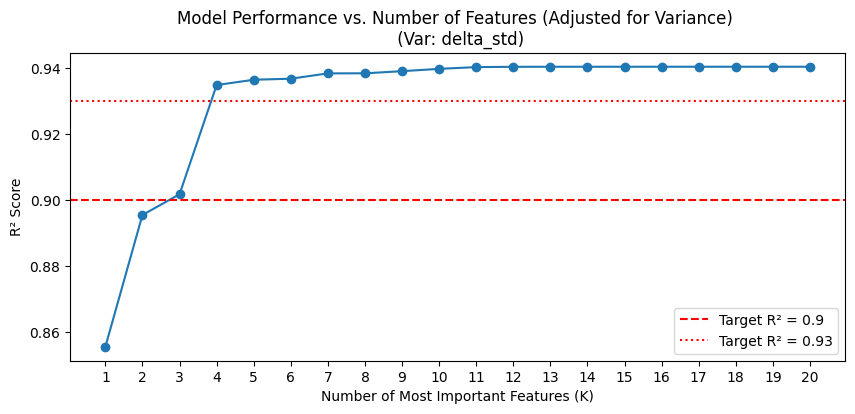

In [ ]:
# 1. Calculate feature importance by scaling coefficients by the standard deviation
feature_importance = np.abs(model.coef_ * np.std(X_poly, axis=0))

# Get the indices of features sorted by this new importance metric
important_indices = np.argsort(feature_importance)[::-1]

# 2. Iteratively calculate R² for models with K features
r2_scores = []
k_features = range(1, len(model.coef_) + 1)

for k in k_features:
    # Select the top k most important feature indices
    top_k_indices = important_indices[:k]

    # Create a reduced dataset with only these features
    X_reduced = X_poly[:, top_k_indices]

    # Fit a new, simpler model on the reduced data
    model_k = LinearRegression()
    model_k.fit(X_reduced, HE[VAR_TO_EXPLAIN])

    # Calculate and store the R² score
    r2_scores.append(model_k.score(X_reduced, HE[VAR_TO_EXPLAIN]))

# 3. Plot the results
plt.figure(figsize=(10, 4))
plt.plot(k_features, r2_scores, marker="o", linestyle="-")
plt.xticks(k_features)

plt.xlabel("Number of Most Important Features (K)")
plt.ylabel("R² Score")
plt.title(f"Model Performance vs. Number of Features (Adjusted for Variance) \n (Var: {VAR_TO_EXPLAIN})")

# Add a reference line for your R² target
plt.axhline(0.9, color="red", linestyle="--", label="Target R² = 0.9")
plt.axhline(0.93, color="red", linestyle=":", label="Target R² = 0.93")
plt.legend()
plt.show()

In [ ]:
# Let's print the top 4 equation here

TOPK = 6

# Create a reduced dataset with only these features
X_reduced = X_poly[:, important_indices[:TOPK]]

# Fit a new, simpler model on the reduced data
model_k = LinearRegression()
model_k.fit(X_reduced, HE[VAR_TO_EXPLAIN])

# Calculate and store the R² score
print(f"R² for model_k with {TOPK} features: {model_k.score(X_reduced, HE[VAR_TO_EXPLAIN])}")
equation_str = get_equation_str(model, poly, EXPLANATORY_VARS, VAR_TO_EXPLAIN, X_poly, k=TOPK)
print(f"Parsimonious equation for {VAR_TO_EXPLAIN} with log transformation:\n{equation_str}")

R² for model_k with 6 features: 0.9368281706029855
Parsimonious equation for delta_std with log transformation:
delta_std = 0.6686 - 0.2293 * n + 0.0251 * n^2 - 0.0099 * d n + 0.0302 * d + 0.0019 * d^2 - 0.0001 * K^2


# What is the delta-distribution actually shaped like?

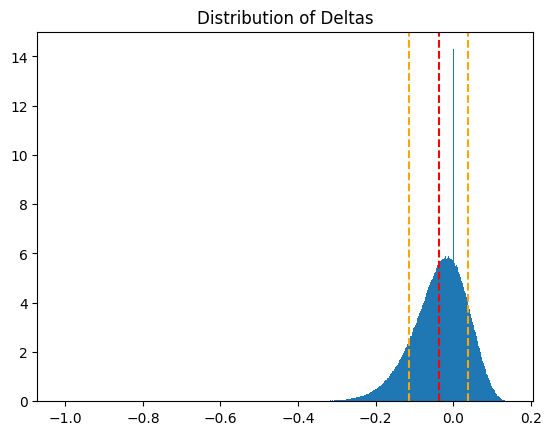

In [ ]:
import manify
import torch
from itertools import permutations
import matplotlib.pyplot as plt


def flatten_deltas(X):
    # Return i != j != k flattened entries of n x n x n tensor
    n = X.shape[0]
    idx = torch.triu_indices(n, n, offset=1)
    # For 3D: get all unique (i, j, k) with i != j != k
    # We'll use permutations for all unique triplets
    triplets = torch.tensor(list(permutations(range(n), 3)))
    i, j, k = triplets[:, 0], triplets[:, 1], triplets[:, 2]
    return X[i, j, k]


K = -1
D = 8
N = 200
BINS = 1000

# Get the deltas
pm = manify.ProductManifold(signature=[(K, D)])
X, _ = pm.sample(torch.stack([pm.mu0] * N))
pdists = pm.pdist(X)
deltas = manify.curvature_estimation.vectorized_delta_hyperbolicity(pdists, full=True)
deltas = flatten_deltas(deltas)

# Get the mean and std of deltas
delta_mean = deltas.mean().detach().numpy()
delta_std = deltas.std().detach().numpy()

plt.hist(deltas.flatten().detach().numpy(), bins=BINS, density=True)
plt.axvline(delta_mean, color="red", linestyle="--", label=f"Mean: {delta_mean:.2f}")
plt.axvline(delta_mean + delta_std, color="orange", linestyle="--", label=f"Std: {delta_std:.2f}")
plt.axvline(delta_mean - delta_std, color="orange", linestyle="--")
plt.title("Distribution of Deltas")
plt.show()

--- Fitting models on 1000000 samples ---


/Users/phil/miniforge3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:707: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


--- Model Comparison (lower AIC is better) ---
           Beta: AIC = -1650015.03
    Skew-Normal: AIC = -1449149.88
  Flipped Gamma: AIC = -1672378.02
     Students t: AIC = -1554044.03

Best model based on AIC: Flipped Gamma

--- Generating Q-Q plots using 100 samples for speed ---


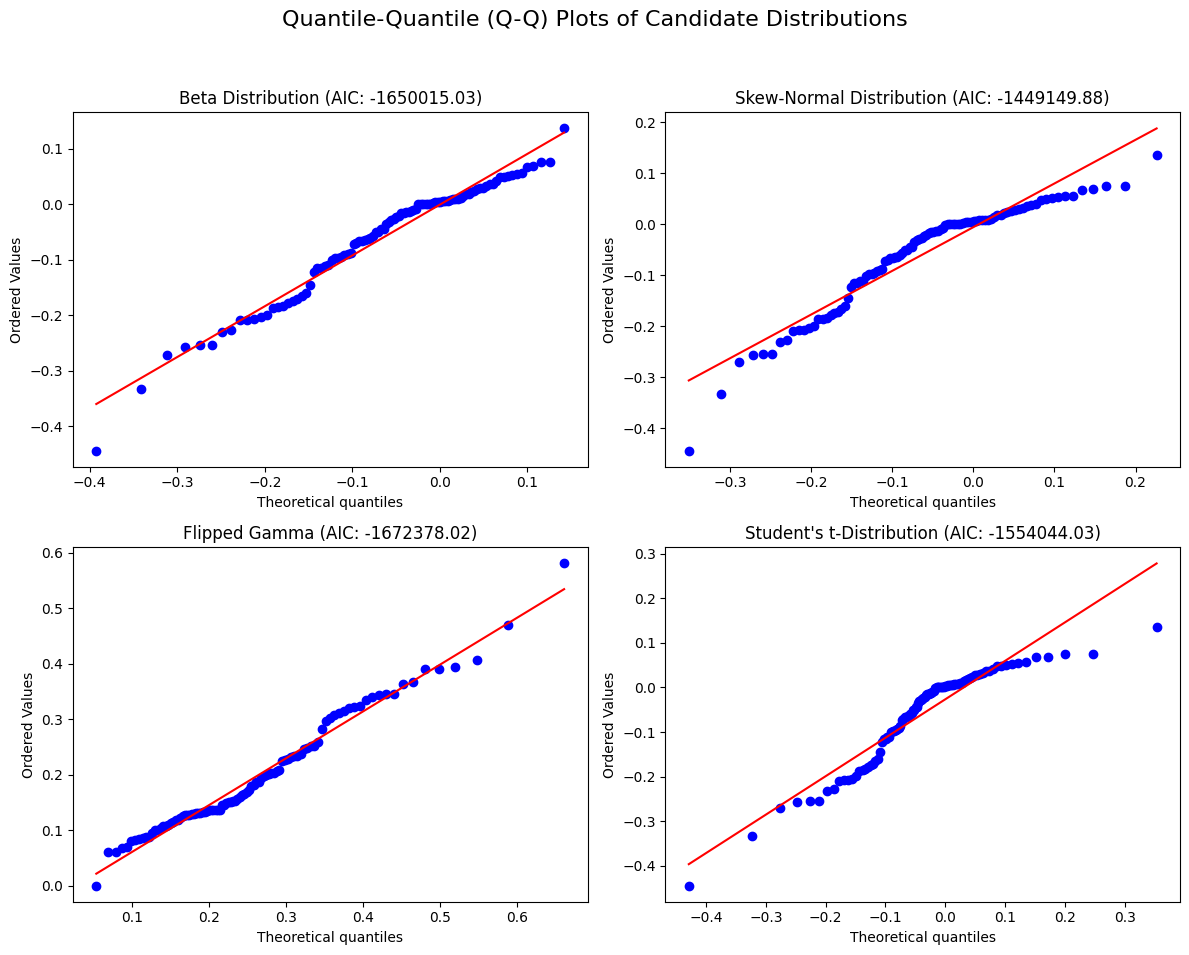

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# --- 1. Data Preparation (Decoupled for Speed) ---
# Your excellent suggestion: use a large sample for fitting and a small one for plotting.
FIT_SAMPLES = 1_000_000  # For statistical accuracy in fitting and AIC
PLOT_SAMPLES = 200  # For fast, clear visualizations

# Convert the torch.Tensor to a flat NumPy array
deltas_np = deltas.flatten().detach().numpy()

# Create the large sample for fitting
if len(deltas_np) > FIT_SAMPLES:
    fit_sample = np.random.choice(deltas_np, FIT_SAMPLES, replace=False)
else:
    fit_sample = deltas_np

# Create the smaller sample for plotting
if len(deltas_np) > PLOT_SAMPLES:
    # It's good practice to sample from the original data again for the plot
    plot_sample = np.random.choice(deltas_np, PLOT_SAMPLES, replace=False)
else:
    plot_sample = deltas_np


# --- 2. Fit Candidate Distributions (using the large 'fit_sample') ---
print(f"--- Fitting models on {len(fit_sample)} samples ---")
fit_results = {}

# Candidate 1: Beta Distribution
params_beta = stats.beta.fit(fit_sample)
fit_results["Beta"] = {"dist": stats.beta, "params": params_beta}

# Candidate 2: Skew-Normal Distribution
params_skewnorm = stats.skewnorm.fit(fit_sample)
fit_results["Skew-Normal"] = {"dist": stats.skewnorm, "params": params_skewnorm}

# Candidate 3: Flipped Gamma Distribution
# The transformation is based on the large 'fit_sample'
fit_max = np.max(fit_sample)
flipped_fit_sample = fit_max - fit_sample + 1e-9  # Add tiny value to avoid zeros
params_gamma = stats.gamma.fit(flipped_fit_sample)
fit_results["Flipped Gamma"] = {"dist": stats.gamma, "params": params_gamma}

# Candidate 4: Students t-Distribution
params_t = stats.t.fit(fit_sample)
fit_results["Students t"] = {"dist": stats.t, "params": params_t}


# --- 3. Compare Models using AIC (also on the large 'fit_sample') ---
print("--- Model Comparison (lower AIC is better) ---")
aic_scores = {}
for name, result in fit_results.items():
    params = result["params"]
    k = len(params)  # Number of parameters

    # Calculate log-likelihood on the appropriate sample
    if name == "Flipped Gamma":
        log_likelihood = np.sum(result["dist"].logpdf(flipped_fit_sample, *params))
    else:
        log_likelihood = np.sum(result["dist"].logpdf(fit_sample, *params))

    # Calculate AIC
    aic = 2 * k - 2 * log_likelihood
    aic_scores[name] = aic
    print(f"{name:>15}: AIC = {aic:.2f}")

best_model_name = min(aic_scores, key=aic_scores.get)
print(f"\nBest model based on AIC: {best_model_name}")


# --- 4. Visual Diagnosis (using the small 'plot_sample' for speed) ---
print(f"\n--- Generating Q-Q plots using {len(plot_sample)} samples for speed ---")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Quantile-Quantile (Q-Q) Plots of Candidate Distributions", fontsize=16)

# Plot for Beta
stats.probplot(plot_sample, dist=fit_results["Beta"]["dist"], sparams=fit_results["Beta"]["params"], plot=axes[0, 0])
axes[0, 0].set_title(f"Beta Distribution (AIC: {aic_scores['Beta']:.2f})")

# Plot for Skew-Normal
stats.probplot(
    plot_sample, dist=fit_results["Skew-Normal"]["dist"], sparams=fit_results["Skew-Normal"]["params"], plot=axes[0, 1]
)
axes[0, 1].set_title(f"Skew-Normal Distribution (AIC: {aic_scores['Skew-Normal']:.2f})")

# Plot for Flipped Gamma
# We need to transform the smaller plot_sample for this specific plot
plot_max = np.max(plot_sample)
flipped_plot_sample = plot_max - plot_sample + 1e-9
stats.probplot(
    flipped_plot_sample,
    dist=fit_results["Flipped Gamma"]["dist"],
    sparams=fit_results["Flipped Gamma"]["params"],
    plot=axes[1, 0],
)
axes[1, 0].set_title(f"Flipped Gamma (AIC: {aic_scores['Flipped Gamma']:.2f})")

# Plot for Students t
stats.probplot(
    plot_sample, dist=fit_results["Students t"]["dist"], sparams=fit_results["Students t"]["params"], plot=axes[1, 1]
)
axes[1, 1].set_title(f"Student's t-Distribution (AIC: {aic_scores['Students t']:.2f})")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Fitting distributions to data...


/Users/phil/miniforge3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Fitting complete.


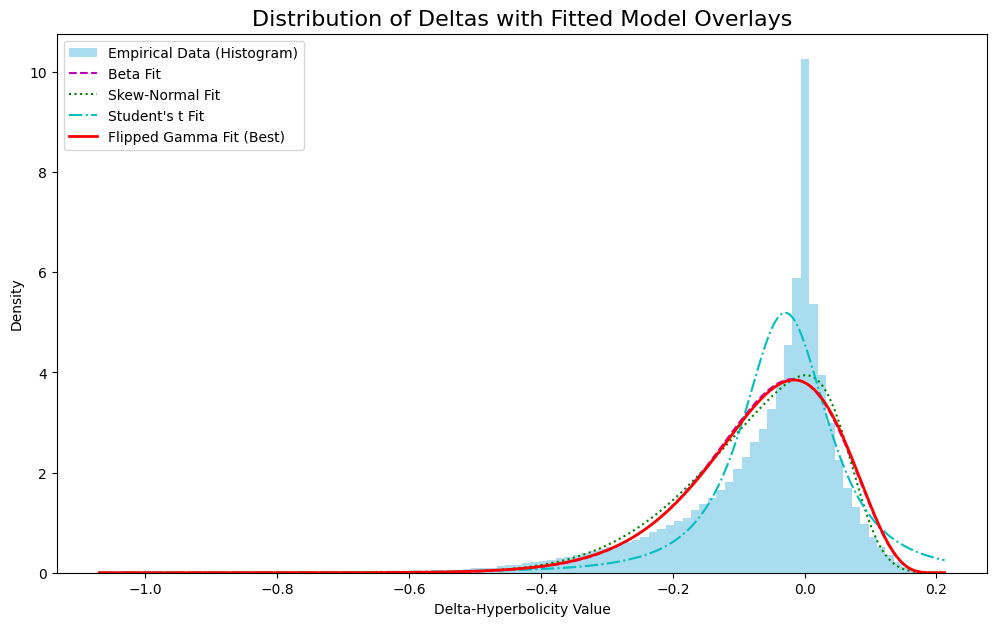

In [ ]:
import manify
import torch
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# --- 1. Data Generation (from your original code) ---
pm = manify.ProductManifold(signature=[(-1, 2)])
X, _ = pm.sample(torch.stack([pm.mu0] * 200))
pdists = pm.pdist(X)
deltas = manify.curvature_estimation.vectorized_delta_hyperbolicity(pdists, full=True)
deltas_np = deltas.flatten().detach().numpy()


# --- 2. Fit all four candidate distributions ---
# Use a large sample size for accurate fitting, consistent with your last finding.
FIT_SAMPLES = 100_000
if len(deltas_np) > FIT_SAMPLES:
    fit_sample = np.random.choice(deltas_np, FIT_SAMPLES, replace=False)
else:
    fit_sample = deltas_np

print("Fitting distributions to data...")
# Fit Beta
params_beta = stats.beta.fit(fit_sample)
# Fit Skew-Normal
params_skewnorm = stats.skewnorm.fit(fit_sample)
# Fit Student's t
params_t = stats.t.fit(fit_sample)
# Fit Flipped Gamma
fit_max = np.max(fit_sample)
flipped_fit_sample = fit_max - fit_sample + 1e-9  # Add tiny value to avoid zeros
params_gamma = stats.gamma.fit(flipped_fit_sample)
print("Fitting complete.")


# --- 3. Plotting ---
plt.figure(figsize=(12, 7))

# Plot the histogram of the full dataset
plt.hist(deltas_np, bins=100, density=True, label="Empirical Data (Histogram)", color="skyblue", alpha=0.7)

# Create a smooth range of x-values for plotting the PDFs
x_plot = np.linspace(np.min(deltas_np), np.max(deltas_np), 500)

# Calculate and plot the PDF for each distribution
pdf_beta = stats.beta.pdf(x_plot, *params_beta)
plt.plot(x_plot, pdf_beta, "m--", label="Beta Fit")

pdf_skewnorm = stats.skewnorm.pdf(x_plot, *params_skewnorm)
plt.plot(x_plot, pdf_skewnorm, "g:", label="Skew-Normal Fit")

pdf_t = stats.t.pdf(x_plot, *params_t)
plt.plot(x_plot, pdf_t, "c-.", label="Student's t Fit")

# For the Flipped Gamma, we evaluate its PDF on the "flipped" x-axis
pdf_gamma = stats.gamma.pdf(fit_max - x_plot, *params_gamma)
plt.plot(x_plot, pdf_gamma, "r-", linewidth=2, label="Flipped Gamma Fit (Best)")


# Add labels and title
plt.title("Distribution of Deltas with Fitted Model Overlays", fontsize=16)
plt.xlabel("Delta-Hyperbolicity Value")
plt.ylabel("Density")
plt.legend()
plt.show()

In [ ]:
deltas_np = deltas[0].detach().numpy()
np.savetxt("deltas.txt", deltas_np, fmt="%.6f")